# Introduction

OpenAssistant-Guanaco is a project focused on developing and fine-tuning chatbot models using a dataset of multilingual human-written simulated conversations. In these conversations, individuals interact with a chatbot assistant, with the twist that the responses from the assistant were authored by real people through crowdsourcing. This dataset offers a diverse range of conversational scenarios, allowing for the training and refinement of chatbot models in various languages and contexts. The primary task associated with this project involves fine-tuning chatbot models using this dataset to enhance their conversational capabilities and overall performance.

## Team Members

- Balice Matteo

- Doronzo Antonio Giuseppe

- Fabris Filip

- Masini Alessandro

# Index

2. [Analysis](#analysis)
    - [General analysis](##general-analysis)
    - [Word2Vec](##word2vec)
    - [Clustering](##clustering)

3. [Training](#training)
4. [Evaluation](#training)
5. [Conclusion](#conclusion)


### Packages

#### Install additional packages

In [ ]:
!pip install datasets
!pip install --upgrade gensim
!pip install langdetect
!pip install plotly

#### Import packages

In [2]:
from datasets import load_dataset
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import random, re
from gensim.models.word2vec import Word2Vec
from langdetect import detect
from pandas.core.common import flatten
from sklearn.manifold import TSNE

# Analysis

### General analysis

#### Import dataset

In [3]:
dataset = load_dataset("timdettmers/openassistant-guanaco")

Repo card metadata block was not found. Setting CardData to empty.


#### Analysis of dataset

In [ ]:
print("Dataset Structure:\n", dataset)
print("\nAvailable Splits:", dataset.keys())

In [4]:
train_df = pd.DataFrame(dataset['train'], columns=['text'])
test_df = pd.DataFrame(dataset['test'], columns=['text'])

In [5]:
df = pd.concat([train_df, test_df], axis=0)

In [ ]:
print("\nFirst few entries of the dataset:")
print(df.head())

##### Example of Human - Assistant Interaction

In [ ]:
df.iloc[0]['text'].split("###")

##### Sentence length analysis

In [ ]:
df['token_length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['token_length'], bins=30, kde=True)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [ ]:
min_length = df['token_length'].min()
max_length = df['token_length'].max()
avg_length = df['token_length'].mean()

print(f"Minimum Length: {min_length}")
print(f"Maximum Length: {max_length}")
print(f"Average Length: {avg_length}")

#### Search Engine

In [ ]:
import pyterrier as pt

if not pt.started():
    pt.init()

In [ ]:
df["docno"] = [str(i) for i in range(1, len(df) + 1)]

In [ ]:
df.info()

In [ ]:
indexer = pt.DFIndexer(
    "c:\\Users\\filip\\Desktop\\NLP-project\\local\\index", overwrite=True
)
index_ref = indexer.index(df["text"], df["docno"])
index_ref.toString()

In [ ]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

In [ ]:
query = "human"

bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25.search(query).head(10)

In [ ]:
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [ ]:
query = "human"

In [ ]:
pipeline = ((tf % 10) | (tf_idf % 10)) >> bm25

pipeline.search(query)

#### Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(df["text"])
len(vectorizer.get_feature_names_out())

In [ ]:
import nltk

# Download stop words from NLTK for the languages you are interested in.
nltk.download("stopwords")
from nltk.corpus import stopwords

english_stop_words = set(stopwords.words("english"))
spanish_stop_words = set(stopwords.words("spanish"))

# Combine the stop words sets.
combined_stop_words = english_stop_words.union(spanish_stop_words)
combined_stop_words = list(combined_stop_words)

In [ ]:
vectorizer = CountVectorizer(min_df=8, stop_words=combined_stop_words)
X = vectorizer.fit_transform(df["text"])
len(vectorizer.get_feature_names_out())

In [ ]:
print(*vectorizer.get_feature_names_out())

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Sum up the counts of each term in all documents
sums = X.sum(axis=0)  # Sum over columns to get total counts for each feature

# Connecting term names with their sums
freq = [(word, sums[0, idx]) for word, idx in zip(feature_names, range(sums.shape[1]))]
# Sorting the list of tuples by frequency
sorted_freq = sorted(freq, key=lambda x: x[1], reverse=True)

# Creating DataFrame from the sorted frequencies for easier plotting
freq_df = pd.DataFrame(sorted_freq, columns=["term", "frequency"])

# Plotting the top N most frequent terms
top_n = 20
plt.figure(figsize=(10, 8))  # Set the figure size
sns.barplot(data=freq_df.head(top_n), x="frequency", y="term", palette="viridis")
plt.title("Top 20 Most Frequent Terms")
plt.xlabel("Frequency")
plt.ylabel("Terms")
plt.show()

In [ ]:
# make another plot with the most frequent terms that most frequently appear like bubble chart, use data which you have

# Plotting the top N most frequent terms

plt.figure(figsize=(10, 8))  # Set the figure size

sns.scatterplot(data=freq_df.head(top_n), x="frequency", y="term", size="frequency", sizes=(100, 1000), palette="viridis")
plt.title("Top 20 Most Frequent Terms")
plt.xlabel("Frequency")
plt.ylabel("Terms")
plt.show()


### Word2Vec

In [6]:
docs = dataset['train']['text'] + dataset['test']['text']

def filter_english(strings):
  english_strings = []
  for string in strings:
    try:
      if detect(string) == 'en':
        english_strings.append(string)
    except:
      print(f"Error with {string}")
  return english_strings

docs = filter_english(docs)
docs[:5]

Error with ### Human: Generate me an ASCII of a person with a jetpack### Assistant: Here is an ASCII art representation of a person with a jetpack:

─────────▄███████████▄▄──────────────
──────▄██▀──────────▀▀██▄────────────
────▄█▀────────────────▀██───────────
──▄█▀────────────────────▀█▄─────────
─█▀──██──────────────██───▀██────────
█▀──────────────────────────██───────
█──███████████████████───────█───────
█────────────────────────────█───────
█────────────────────────────█───────
█────────────────────────────█───────
█────────────────────────────█───────
█────────────────────────────█───────
█▄───────────────────────────█───────
▀█▄─────────────────────────██───────
─▀█▄───────────────────────██────────
──▀█▄────────────────────▄█▀─────────
───▀█▄──────────────────██───────────
─────▀█▄──────────────▄█▀────────────
───────▀█▄▄▄──────▄▄▄███████▄▄───────
────────███████████████───▀██████▄───
─────▄███▀▀────────▀███▄──────█─███──
───▄███▄─────▄▄▄▄────███────▄▄████▀──
─▄███▓▓█─────█▓

['### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power, lea

Let's separate the sentences written by the human from the ones of the assistant:

In [7]:
human_questions = []
assistant_answers = []

for string in docs:
  segments = string.split("### Human:")
  for segment in segments[1:]:
    #This if is added to add to the list of questions only those that have then received an answer
    if "### Assistant:" in segment:
      human_questions.append(segment.split("### Assistant:")[0].strip())

  segments = string.split("### Assistant:")
  for segment in segments[1:]:
      assistant_answers.append(segment.split("### Human:")[0].strip())

print(len(human_questions))
print(len(assistant_answers))

5495
5495


Let's clean the datasets and split them into different sentences:

In [8]:
human_questions = [re.sub('[\n\t]', '', doc) for doc in human_questions]
assistant_answers = [re.sub('[\n\t]', '', doc) for doc in assistant_answers]
human_questions = [re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', doc) for doc in human_questions]
assistant_answers = [re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', doc) for doc in assistant_answers]
human_questions = [re.split('[?!.]\s', doc) for doc in human_questions]
assistant_answers = [re.split('[?!.]\s', doc) for doc in assistant_answers]

Flatten the list of lists and tokenize each word:

In [9]:
human_questions = list(flatten(human_questions))
human_questions = [re.sub('\W', ' ', doc).lower().split() for doc in human_questions]

assistant_answers = list(flatten(assistant_answers))
assistant_answers = [re.sub('\W', ' ', doc).lower().split() for doc in assistant_answers]

#We also compute a combination of the two tet
full_text = human_questions + assistant_answers

 The minimum length of each sentence is 5, so we don't need to remove sentences that are composed by few words

 Now we train the Word2Vec on the human questions, by providing as input the tokenized words, the size of each embedding, the minimum number of occurences for each word and the context window size:



In [10]:
model_human = Word2Vec(human_questions, vector_size=30, min_count=5, window=10)

How many words do we have in our model?

In [11]:
len(model_human.wv)

2920

How is each embedding vector made?

In [ ]:
term = 'house'
model_human.wv[term]

What are the most similar words to the word "short" ?

In [ ]:
term = 'short'
model_human.wv.most_similar(term)

Now, let's do the same thing but with the assistant answers:

In [12]:
model_assistant = Word2Vec(assistant_answers, vector_size=30, min_count=5, window=10)

It's vocabulary size is more than 4 times the human one:

In [13]:
len(model_assistant.wv)

12125

Let's see an example of embedding:

In [ ]:
term = 'house'
model_assistant.wv[term]

And the most similar words to the word "short":

In [ ]:
term = 'short'
model_assistant.wv.most_similar(term)

Finally, let's perform the same operations with the full_text to our disposal:

In [14]:
model_full = Word2Vec(full_text, vector_size=30, min_count=5, window=10)

The length of the vocabulary isn't much different from the one of just the assistant:

In [ ]:
len(model_full.wv)

Let's again an example of an embedding:

In [ ]:
term = 'plant'
model_full.wv[term]

And once again the most similar word to the word short:

In [ ]:
term = 'short'
model_full.wv.most_similar(term)

Has the model understood the relation between this words?

In [ ]:
vec = model_full.wv['king'] + (model_full.wv['woman'] - model_full.wv['man'])
vec

Seems it does not:

In [ ]:
model_full.wv.most_similar(vec)

And this kind of relation?

In [ ]:
vec = model_full.wv['france'] + (model_full.wv['rome'] - model_full.wv['italy'])
vec

It seems to have a better idea of what we are talking about, but still he hasn't fully understood the relation:

In [ ]:
model_full.wv.most_similar(vec)

#Visualizing the embedding vector using t-SNE

We'll now produce a graphical representation of a subset of the embeddings, because to reduce the time required for computation, we'll limit our representation to 500 random samples:

In [21]:
random_samples_human = random.sample(list(model_human.wv.key_to_index), len(model_human.wv.key_to_index))
word_vectors_human = model_human.wv[random_samples_human]


random_samples_assistant = random.sample(list(model_assistant.wv.key_to_index), 500)
word_vectors_assistant = model_assistant.wv[random_samples_assistant]

random_samples_full = random.sample(list(model_full.wv.key_to_index), 500)
word_vectors_full = model_full.wv[random_samples_full]

We'll provide the vectors to the TSNE algorithm, to fit a model and have a 3 dimensional representation:

In [22]:
tsne = TSNE(n_components=3, n_iter=2000)

tsne_embeddings_human = tsne.fit_transform(word_vectors_human)
tsne_embeddings_assistant = tsne.fit_transform(word_vectors_assistant)
tsne_embeddings_full = tsne.fit_transform(word_vectors_full)

We transpose the matrix, as to have each dimension in each row of the resulting matrix and we get the coordinates of each point:

In [15]:
x_human, y_human, z_human = np.transpose(tsne_embeddings_human)
x_assistant, y_assistant, z_assistant = np.transpose(tsne_embeddings_assistant)
x_full, y_full, z_full = np.transpose(tsne_embeddings_full)

We draw the plots (we also reduced the amount of samples to be shown for a better representation):

In [ ]:
fig = px.scatter_3d(x=x_human[:150], y=y_human[:150], z=z_human[:150], text=random_samples_human[:150])
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

In [ ]:
fig = px.scatter_3d(x=x_assistant[:150], y=y_assistant[:150], z=z_assistant[:150], text=random_samples_assistant[:150])
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

In [ ]:
fig = px.scatter_3d(x=x_full[:150], y=y_full[:150], z=z_full[:150], text=random_samples_full[:150])
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

### Clustering

Automatic clustering based on the embeddings of the word2vec model.
We put a threshold of 0.95 to have a good clustering.

We use the cosine similarity to calculate the distance between the embeddings.

In [40]:
def cosine_similarity_matrix(embeddings):
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)
    return similarity_matrix

def find_similar_groups(embeddings, threshold):
    similarity_matrix = cosine_similarity_matrix(embeddings)
    n = len(embeddings)
    visited = set()
    similar_groups = []

    for i in range(n):
        if i not in visited:
            similar_group = [i]
            visited.add(i)
            for j in range(i+1, n):
                if j not in visited and similarity_matrix[i][j] >= threshold:
                    similar_group.append(j)
                    visited.add(j)
            similar_groups.append(similar_group)

    return similar_groups

threshold = 0.99
embeddings_word2vec = model_full.wv.vectors
similar_groups = find_similar_groups(embeddings_word2vec, threshold)

i = 0
for _, group in enumerate(similar_groups):
    if len(group) == 1:
        continue
    print(f"Cluster {i}:")
    print([model_full.wv.index_to_key[idx] for idx in group])
    i += 1


Gruppo 0:
['salt', 'pepper']
Gruppo 1:
['landroid', 'hidl', 'lang', 'ljava', 'throws', 'remoteexception', 'v1_0']
Gruppo 2:
['garlic', 'onion']
Gruppo 3:
['td', 'tr']
Gruppo 4:
['annotation', 'ldalvik']
Gruppo 5:
['partial', 'l_j']
Gruppo 6:
['rick', 'morty']
Gruppo 7:
['sticky', 'tk_calc', 'nsew', 'button_click']
Gruppo 8:
['calc_operator', 'text_input']
Gruppo 9:
['con', 'para', 'interfaz']
Gruppo 10:
['ich', 'liebe']
Gruppo 11:
['__name__', '__main__']
Gruppo 12:
['yt', 'dlp']
Gruppo 13:
['una', 'ejemplo']
Gruppo 14:
['file_name', 'bucket_name']
Gruppo 15:
['und', 'für']
Gruppo 16:
['arraylist', 'util']
Gruppo 17:
['в', 'и', 'для']
Gruppo 18:
['x1', 'x2', 'y1', 'y2']
Gruppo 19:
['columna', 'fila']
Gruppo 20:
['kong', 'hong']
Gruppo 21:
['cur_mat', 'cover_cols']
Gruppo 22:
['sliced', 'ginger']
Gruppo 23:
['ihwbinder', 'invoke']
Gruppo 24:
['num1', 'num2']
Gruppo 25:
['padx', 'pady']
Gruppo 26:
['mai', '4096']
Gruppo 27:
['0100000', '01100101', '01110100']
Gruppo 28:
['salute', 'bella

Clustering based on the languages of the sentences.

In [37]:
documents_languages = df['text'].tolist()

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
vectorizer.fit(documents_languages)
vector_documents = vectorizer.transform(documents_languages)

In [39]:
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 25278


In [40]:
from sklearn.cluster import KMeans

# Number of clusters (languages)
k = 5

kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_documents)
labels = kmeans.labels_

Initialization complete
Iteration 0, inertia 19066.86348156223.
Iteration 1, inertia 9777.833360920173.
Iteration 2, inertia 9727.879977278117.
Iteration 3, inertia 9714.72384395386.
Iteration 4, inertia 9708.532428565324.
Iteration 5, inertia 9705.10994454273.
Iteration 6, inertia 9703.592703383765.
Iteration 7, inertia 9702.759291833163.
Iteration 8, inertia 9702.212832366673.
Iteration 9, inertia 9701.833054432447.
Iteration 10, inertia 9701.506544784046.
Iteration 11, inertia 9701.2759424376.
Iteration 12, inertia 9701.096030889054.
Iteration 13, inertia 9700.969042104341.
Iteration 14, inertia 9700.882757062569.
Iteration 15, inertia 9700.80470524187.
Iteration 16, inertia 9700.732471772797.
Iteration 17, inertia 9700.682269408722.
Iteration 18, inertia 9700.654306258042.
Iteration 19, inertia 9700.629212633317.
Iteration 20, inertia 9700.617330322486.
Iteration 21, inertia 9700.612084593213.
Iteration 22, inertia 9700.610622983.
Converged at iteration 22: strict convergence.
Init

In [41]:
for idx in range(k):
  centroid = kmeans.cluster_centers_[idx]

  # Sort terms according to their weights 
  # (argsort goes from lowest to highest, we reverse the order through slicing)
  sorted_terms = centroid.argsort()[::-1]

  # Print out the top 10 terms for the cluster
  print("Cluster " + str(idx) + ":")
  print([vocab[j] for j in sorted_terms[:20]])

Cluster 0:
['die', 'und', 'der', 'et', 'zu', 'des', 'ist', 'est', 'les', 'ich', 'eine', 'le', 'von', 'sie', 'du', 'das', 'pour', 'une', 'ein', 'mit']
Cluster 1:
['la', 'en', 'el', 'que', 'los', 'una', 'se', 'es', 'las', 'para', 'del', 'por', 'su', 'como', 'más', 'lo', 'puede', 'al', 'son', 'ser']
Cluster 2:
['use', 'like', 'help', 'time', 'data', 'ai', 'make', 'open', 'language', 'used', 'using', 'world', 'code', 'model', 'new', 'example', 'need', 'di', 'people', 'create']
Cluster 3:
['на', 'не', 'что', 'для', 'как', 'это', 'или', 'из', 'может', 'то', 'вы', 'если', 'по', 'от', 'но', 'чтобы', 'за', 'ты', 'он', 'его']
Cluster 4:
['que', 'en', 'el', 'la', 'una', 'para', 'es', 'los', 'se', 'las', 'por', 'del', 'como', 'más', 'te', 'tu', 'si', 'lo', 'su', 'puedes']


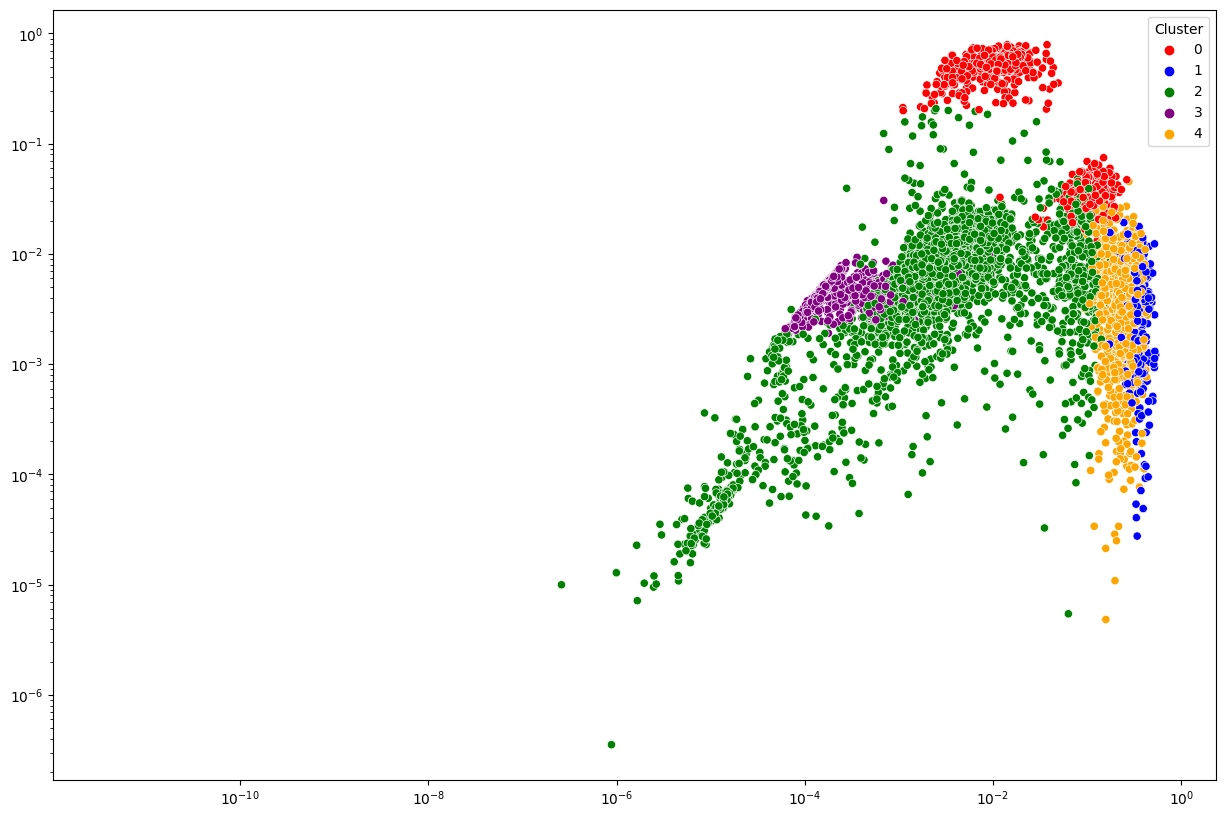

In [42]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
reduced_data = svd.fit_transform(vector_documents)

[x,y] = np.transpose(reduced_data)
fig = plt.figure(figsize=(15, 10))

plt.xscale('log')
plt.yscale('log')
sns.scatterplot(x=x, y=y, hue=labels, palette=['red', 'blue', 'green', 'purple', 'orange'])
plt.legend(title="Cluster")

# Training